In [33]:
# Libraries

import sqlite3
import pandas as pd
from pathlib import Path
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt



In [38]:
# Format

pd.options.display.float_format = '{:,.2f}'.format

# Paths
DB_PATH = Path("../data/processed/HVT_Analysis_Final.db")

# Load the RAW Data
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT * FROM Physician_Nexus_Raw", conn)

# --- DIAGNOSIS ---
print("DATA DIAGNOSIS REPORT")
print("-" * 30)
print(f"df Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Data Types:\n{df.dtypes}")
print(f"Columns with Nulls:\n{df.isnull().sum()[df.isnull().sum() > 0]}")


DATA DIAGNOSIS REPORT
------------------------------
df Shape: (87297, 8)
Columns: ['ID', 'First_Name', 'Last_Name', 'Specialty', 'Commercial_Spend', 'Research_Spend', 'Primary_Manufacturer', 'Total_Spend']
Data Types:
ID                      float64
First_Name               object
Last_Name                object
Specialty                object
Commercial_Spend        float64
Research_Spend          float64
Primary_Manufacturer     object
Total_Spend             float64
dtype: object
Columns with Nulls:
Series([], dtype: int64)


In [41]:
# Create the missing full_name column

df['full_name'] = df['first_name'] + " " + df['last_name']

# 1. Standardize Column Names
df.columns = [col.strip().lower() for col in df.columns]

# 2. Fix the ID (Float64 -> Int64)
# We use 'Int64' (capital I) because it handles nulls better than 'int64'
df['id'] = df['id'].fillna(0).astype('int64')

# 3. Fix String Casing (ALL CAPS -> Title Case)
string_cols = ['first_name', 'last_name', 'full_name', 'specialty', 'primary_manufacturer']
for col in string_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title()

# 4. Handle Financial Precision
money_cols = ['commercial_spend', 'research_spend', 'total_spend']
for col in money_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).round(2)

print("Standardization Complete.")
display(df.head())

Standardization Complete.


,id,first_name,last_name,specialty,commercial_spend,research_spend,primary_manufacturer,total_spend,full_name
0,14,Anita,Gill,Neurology,20.00,0.00,Csl Behring,20.00,Anita Gill
1,18,Moustafa,Banna,Cardiology,"2,527.62",0.00,"Heartflow, Inc.","2,527.62",Moustafa Banna
2,36,Yolanda,Zarate,Neurology,"1,163.77",0.00,Abbvie Inc.,"1,163.77",Yolanda Zarate
3,37,Joseph,Poitier,Neurology,313.93,0.00,Abbvie Inc.,313.93,Joseph Poitier
4,43,Mahta,Ostadian,Neurology,184.49,0.00,Abbvie Inc.,184.49,Mahta Ostadian


##### ANOVA ANALYSIS 

In [28]:
# 1. Isolate the groups for the 'Big Three'
# We are testing if the 'Total_Spend' is statistically different across specialties
onc_group = df[df['specialty'] == 'Oncology']['total_spend']
cardio_group = df[df['specialty'] == 'Cardiology']['total_spend']
neuro_group = df[df['specialty'] == 'Neurology']['total_spend']

# 2. Perform the One-Way ANOVA
f_stat, p_val = stats.f_oneway(onc_group, cardio_group, neuro_group)

print("PHASE I VALIDATION: ANOVA TEST")
print(f"F-Statistic: {f_stat:,.2f}")
print(f"P-Value: {p_val:.4f}")

if p_val < 0.05:
    print("\nVALIDATED: There is a significant difference between specialties.")
    print("Proceed to Phase II: Feature Engineering (Influence Ratio).")
else:
    print("\nNOTICE: No significant difference found. Re-check data distribution.")

PHASE I VALIDATION: ANOVA TEST
F-Statistic: 14.04
P-Value: 0.0000

VALIDATED: There is a significant difference between specialties.
Proceed to Phase II: Feature Engineering (Influence Ratio).


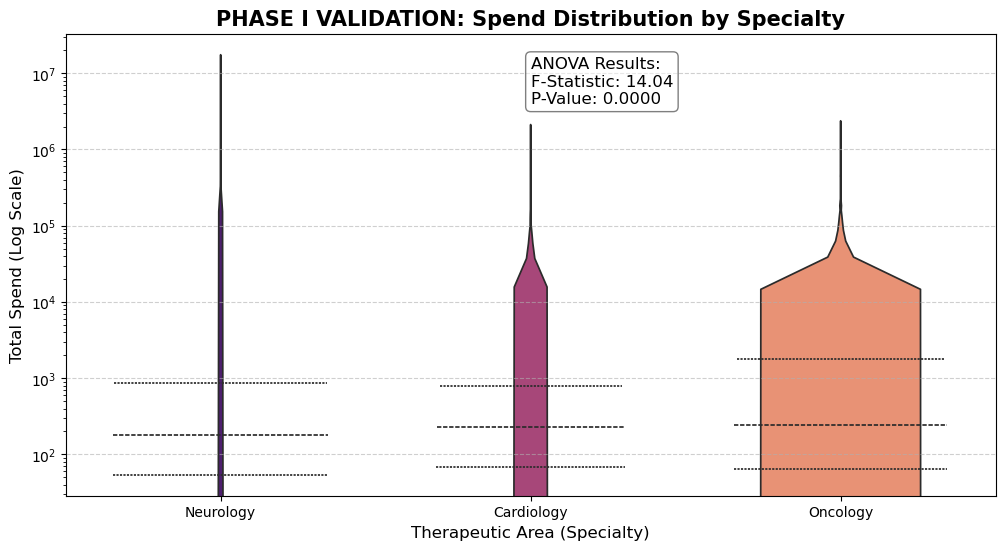

In [31]:
# 1. Setup the figure
plt.figure(figsize=(12, 6))

# 2. Create the Violin Plot 
# We assign 'specialty' to both x and hue to keep the colors consistent
sns.violinplot(
    data=df, 
    x='specialty', 
    y='total_spend', 
    hue='specialty', 
    palette='magma', 
    inner='quartile', 
    legend=False
)

# 3. Add Labels and Titles
plt.yscale('log') # Essential for pharmaceutical spend data
plt.title('PHASE I VALIDATION: Spend Distribution by Specialty', fontsize=15, fontweight='bold')
plt.xlabel('Therapeutic Area (Specialty)', fontsize=12)
plt.ylabel('Total Spend (Log Scale)', fontsize=12)

# 4. Add the ANOVA result as a text box on the chart
stats_text = f"ANOVA Results:\nF-Statistic: 14.04\nP-Value: 0.0000"
plt.text(0.5, 0.95, stats_text, transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Filter for the 1 million outliers
high_rollers = df[df['total_spend'] > 1_000_000].sort_values('total_spend', ascending=False)

print(f"OUTLIER IDENTIFICATION: {len(high_rollers)} Physicians found over $1M")
print("-" * 60)
if not high_rollers.empty:
    display(high_rollers[['full_name', 'specialty', 'primary_manufacturer', 'total_spend', 'research_spend']])
else:
    print("No physicians found over $1,000,000.")

OUTLIER IDENTIFICATION: 10 Physicians found over $1M
------------------------------------------------------------


,full_name,specialty,primary_manufacturer,total_spend,research_spend
11342,Ivan Osorio,Neurology,"Livanova Usa, Inc.","17,456,052.97",0.00
77066,John Pesando,Oncology,"Beckman Coulter, Inc.","2,366,194.17",0.00
44037,Roger Hajjar,Cardiology,Asklepios Biopharmaceutical Inc.,"2,114,077.40",0.00
39890,David Jacofsky,Oncology,Stryker Corporation,"1,743,111.79",0.00
64260,Neil Love,Oncology,"Janssen Scientific Affairs, Llc","1,310,000.00",0.00
38268,Khaldoun Almhanna,Oncology,"Trisalus Life Sciences, Inc.","1,211,074.57","1,177,690.12"
24967,Rakesh Jain,Neurology,"Teva Pharmaceuticals Usa, Inc.","1,124,859.37",0.00
46259,Andrew Cutler,Neurology,"Iti, Inc. (D/B/A Intra-Cellular Therapies, Inc.)","1,080,855.50",0.00
13739,Matthew Budoff,Cardiology,Novo Nordisk Inc,"1,046,892.53","474,468.50"
18450,Leslie Citrome,Neurology,"Teva Pharmaceuticals Usa, Inc.","1,027,564.85",0.00


In [44]:
# 1. Unique manufacturers per specialty
mfg_counts = df.groupby('specialty')['primary_manufacturer'].nunique()

# 2. Top player dominance per specialty
def get_top_mfg_share(group):
    top_mfg_spend = group.groupby('primary_manufacturer')['total_spend'].sum().max()
    total_specialty_spend = group['total_spend'].sum()
    return (top_mfg_spend / total_specialty_spend) * 100

mfg_dominance = df.groupby('specialty').apply(lambda x: get_top_mfg_share(x), include_groups=False)

print("MANUFACTURER CONCENTRATION REPORT")
print("-" * 40)
for spec in mfg_counts.index:
    print(f"{spec}:")
    print(f"  - Unique Manufacturers: {mfg_counts[spec]}")
    print(f"  - Top Player Market Share: {mfg_dominance[spec]:.2f}%")

MANUFACTURER CONCENTRATION REPORT
----------------------------------------
Cardiology:
  - Unique Manufacturers: 349
  - Top Player Market Share: 10.00%
Neurology:
  - Unique Manufacturers: 527
  - Top Player Market Share: 13.53%
Oncology:
  - Unique Manufacturers: 495
  - Top Player Market Share: 10.23%


##### Saving Cleaned Table

In [46]:
# Define the professional order
column_order = [
    'id', 'full_name', 'specialty', 
    'commercial_spend', 'research_spend', 'total_spend', 
    'primary_manufacturer'
]

# Reorder the dataframe
df = df[column_order]

print("✅ Column order standardized: ID -> Full Name -> Specialty -> Metrics")
display(df.head(3))

✅ Column order standardized: ID -> Full Name -> Specialty -> Metrics


,id,full_name,specialty,commercial_spend,research_spend,total_spend,primary_manufacturer
0,14,Anita Gill,Neurology,20.00,0.00,20.00,Csl Behring
1,18,Moustafa Banna,Cardiology,"2,527.62",0.00,"2,527.62","Heartflow, Inc."
2,36,Yolanda Zarate,Neurology,"1,163.77",0.00,"1,163.77",Abbvie Inc.


In [48]:
# --- SAVING THE CLEANED DATA  ---

conn = sqlite3.connect(DB_PATH)

# Save to 'Physician_Nexus_Cleaned'
df.to_sql('Physician_Nexus_Cleaned', conn, if_exists='replace', index=False)

conn.close()
print("SUCCESS: Cleaned data saved!")

SUCCESS: Cleaned data saved!
